# Bringing tomography and pulses together

In [1]:
from qiskit import IBMQ
import qiskit.tools.jupyter
%qiskit_job_watcher

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend(open_pulse=True)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
backend

/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:366: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '
/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def to_ptm(op):
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    ptm = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            ptm[i, j] = (paulis[i] * op * paulis[j] * op.dag()).tr()/2
    return qt.Qobj(ptm)

def rotation(theta, phi, lam):
    U = [[np.cos(theta/2), -np.exp(1j*lam) * np.sin(theta/2)], 
         [np.exp(1j*phi) * np.sin(theta/2), np.exp(1j*lam+1j*phi) * np.cos(theta/2)]]
    return qt.Qobj(U)

def objective(angles, *args):
    theta, phi, lam = angles
    U = to_ptm(rotation(theta, phi, lam))
    G, G_ideal = args
    norm = np.linalg.norm((G_ideal - U * G)) ** 2
    return norm

## Process tomography for the Hadamard gate

In [4]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.execute import execute

register = QuantumRegister(1)
circuit = QuantumCircuit(register)
circuit.h(0)

experiments = process_tomography_circuits(circuit, register[0])
job = execute(experiments, backend, shots=8000)
result = job.result()

print(job.job_id())

5e565379abd90800189ccd48


CP? True. TP? True.
Norm(ideal, real): 0.030388312499999837.


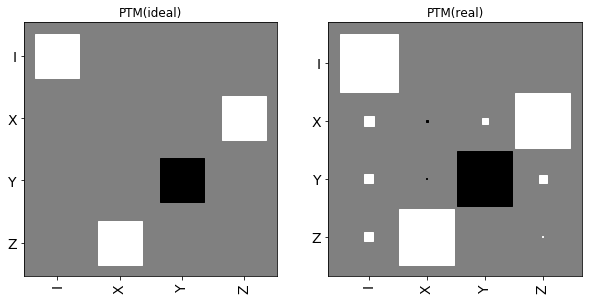

In [12]:
from qiskit.ignis.verification.tomography import ProcessTomographyFitter
from qiskit.quantum_info import PTM
from qiskit.visualization import plot_state_hinton

tomography = ProcessTomographyFitter(result, experiments)
choi = tomography.fit()
ptm = qt.Qobj(PTM(choi).data)

ptm_ideal = to_ptm(qt.hadamard_transform(1))
ptm_norm_before =  np.linalg.norm((ptm - ptm_ideal).full()) ** 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm_ideal.dag(), ax_real=axs[0])
plot_state_hinton(ptm.dag(), ax_real=axs[1])
title_list = ['PTM(ideal)', 'PTM(real)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(PTM(choi).is_cp())+'.', 'TP? '+str(PTM(choi).is_tp())+'.')
print('Norm(ideal, real): '+str(ptm_norm_before)+'.')

## Calculating the gate corrections

[ 0.00031082  0.03930607 -0.04513787]
Norm(ideal, ideal corrected): 0.029781972371172093.


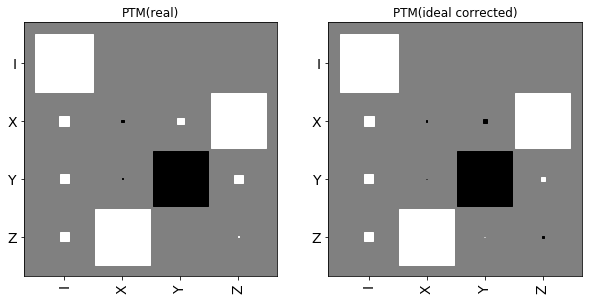

In [13]:
from scipy.optimize import minimize
guess = .5 * np.random.randn(3, 1) 
#bounds = ((np.pi/2, np.pi/2), (np.pi/2, np.pi/2), (np.pi/2, np.pi/2))
solution = minimize(objective, guess, args=(ptm, ptm_ideal), tol=1e-12)
angles = solution.x

theta, phi, lam = angles
U = to_ptm(rotation(theta, phi, lam))

ptm_th = U * ptm
ptm_norm_th =  np.linalg.norm((ptm_th - ptm_ideal).full()) **2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm.dag(), ax_real=axs[0])
plot_state_hinton(ptm_th.dag(), ax_real=axs[1])
title_list = ['PTM(real)', 'PTM(ideal corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print(angles/np.pi)
print('Norm(ideal, ideal corrected): '+str(ptm_norm_th)+'.')

## Process tomography for the "corrected" Hadamard gate

In [9]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

register = QuantumRegister(1)
circuit_corr = QuantumCircuit(register)
circuit_corr.u3(theta, phi, lam, 0)
circuit_corr.h(0)
circuit_corr.u3(-theta, -lam, -phi, 0)

experiments_corr = process_tomography_circuits(circuit_corr, register[0])
job_corr = execute(experiments_corr, backend, shots=8000)
result_corr = job_corr.result()

print(job_corr.job_id())

5e5654de2aeb3b0019f47d61


CP? True. TP? True.
Norm(real corrected, ideal): 0.04579625000000056.
Norm(real corrected, ideal corrected): 0.004014842602147827.


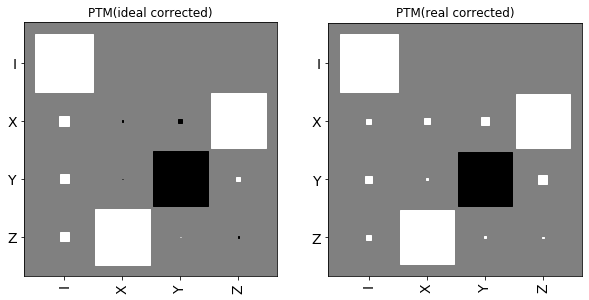

In [14]:
tomography_corr = ProcessTomographyFitter(result_corr, experiments_corr)
choi_corr = tomography_corr.fit()
ptm_corr = qt.Qobj(PTM(choi_corr).data)

ptm_norm_after =  np.linalg.norm((ptm_corr - ptm_ideal).full()) ** 2
ptm_norm_miss =  np.linalg.norm((ptm_corr - ptm_th).full()) ** 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm_th.dag(), ax_real=axs[0])
plot_state_hinton(ptm_corr.dag(), ax_real=axs[1])
title_list = ['PTM(ideal corrected)', 'PTM(real corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(PTM(choi_corr).is_cp())+'.', 'TP? '+str(PTM(choi_corr).is_tp())+'.')
print('Norm(real corrected, ideal): '+str(ptm_norm_after)+'.')
print('Norm(real corrected, ideal corrected): '+str(ptm_norm_miss)+'.')

## Checking native pulses

In [15]:
config = backend.configuration()
defaults = backend.defaults()
inst_sched_map = defaults.instruction_schedule_map
print(inst_sched_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'measure', 'MEAS', 'u3', 'id', 'u2', 'x', 'u1'}
Multi qubit instructions:
)>


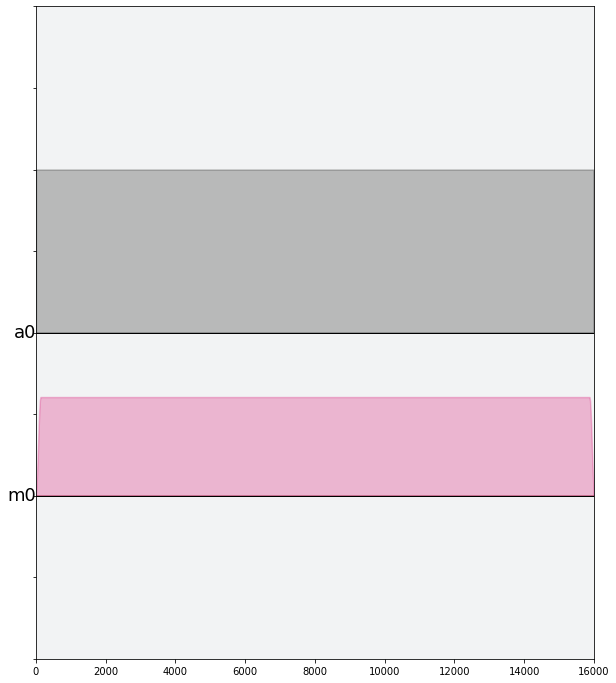

In [16]:
measure = inst_sched_map.get('measure', qubits=config.meas_map[0])
measure.draw()

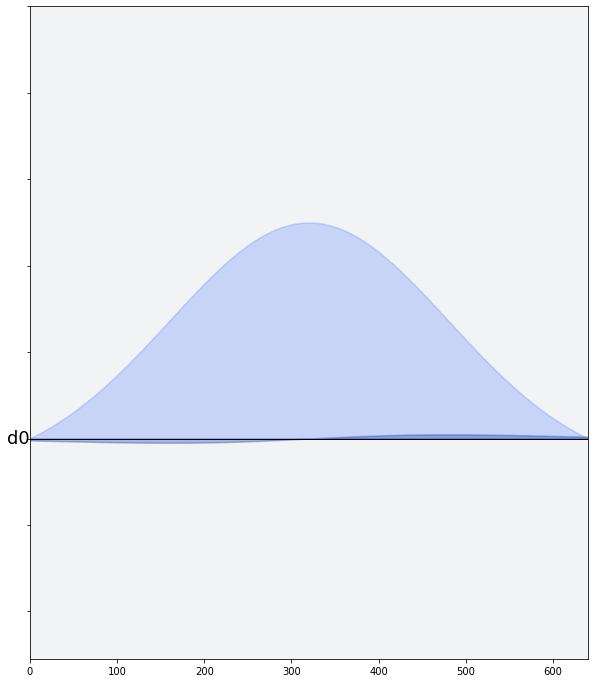

In [17]:
x = inst_sched_map.get('x', qubits=config.meas_map[0])
x.draw()

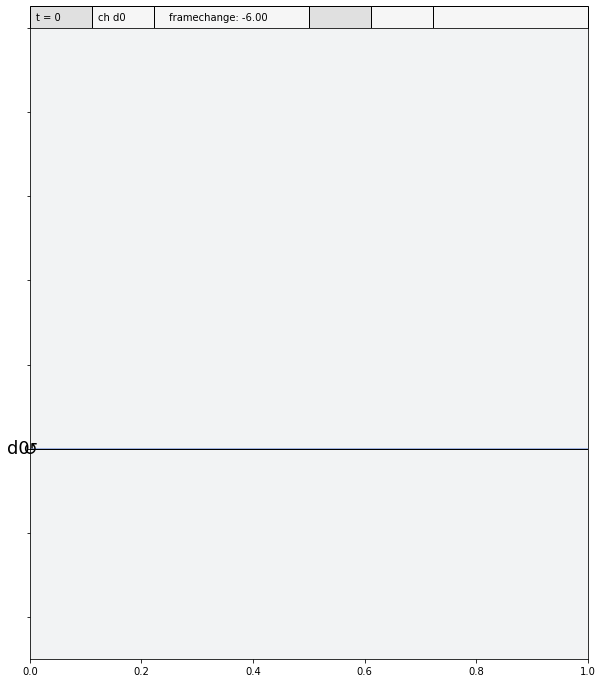

In [18]:
u1 = inst_sched_map.get('u1', 0, 6)
u1.draw()

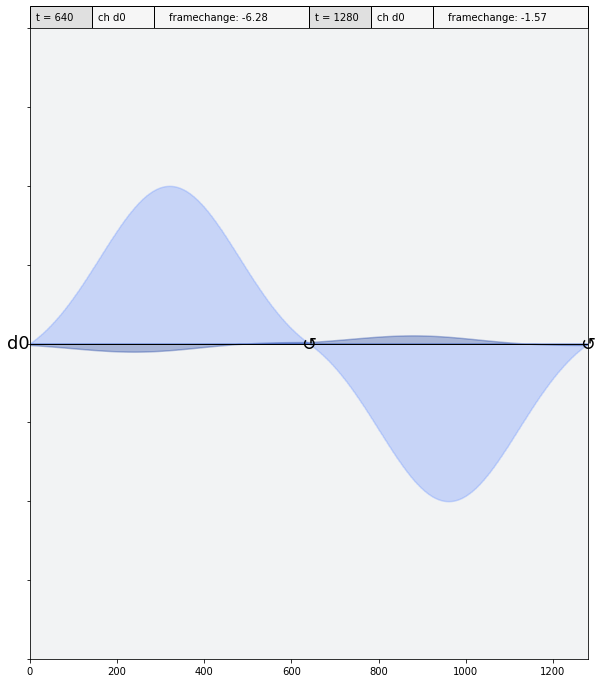

In [19]:
u2 = inst_sched_map.get('u3', 0, 2*np.pi, np.pi/2, 0)
u2.draw()